# Exercise 7: Simulated annealing

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform

## 1. Implement simulated annealing for the travelling salesman. As proposal, permute two random stations on the route. As cooling scheme, you can use e.g. Tk = 1/ √ 1 + k. or Tk = − log(k + 1), feel free to experiment with different choices. The route must end where it started. Initialise with a random permutation of stations.


Below we implement simulated annealing. It takes an initial state, as well as functions to calculate energy, permutations, and temperatures:

In [41]:
def simulated_annealing(initial_state, energy, permute, t_func, N):
    state = initial_state
    energies = np.empty(N)
    accepted = np.zeros(N)

    for k in range(N):
        T = t_func(k)
        proposed_state = permute(state)

        e_state = energy(state)
        e_proposed = energy(proposed_state)

        energies[k] = e_state

        accept_prob = min(1, np.exp(-(e_proposed - e_state) / T))

        if uniform.rvs() < accept_prob:
            state = proposed_state
            accepted[k] = 1
    
    return state, energies, accepted

We then define functions for generating permutations, generating temperature functions, and calculcating energies of states. Note that we abuse the structure of notebooks slightly, n_stations and cost_matrix are not defined yet, but will be when the functions are called.

In [42]:
def permute(state):
    state = state.copy()
    indices = np.random.choice(n_stations, size=2, replace=False)
    state[indices] = state[indices[::-1]]
    return state

def get_t_func(t0, alpha):
    def t_func(k):
        return t0 * alpha ** k
    return t_func

def energy(state):
    cost = 0
    for i in range(n_stations):
        cost += cost_matrix[state[i], state[(i + 1) % n_stations]]
    return cost

### (a) Have input be positions in the plane of the n stations. Let the cost of going i 7→ j be the Euclidian distance between station i and j. Plot the resulting route in the plane.Debug with stations on a circle. 


We create 12 stations placed on a cirlce in the plane, and create the corresponding cost matrix. As seen in the code above, our cooling shceme is $T_k = t_0 \alpha^k$. We then run simulated annealing with the following paramters:

$$N = 500 \quad \text{(number of iterations)}$$
$$t_0 = 100 \quad \text{(temperature at $T=0$)}$$
$$\alpha = 0.975 \quad \text{(temperature scaling factor, per iteration)}$$

In [43]:
np.random.seed(69)

n_stations = 12
stations = np.arange(n_stations)

theta = 2 * np.pi * stations / n_stations
x = np.cos(theta)
y = np.sin(theta)

cost_matrix = np.empty((n_stations, n_stations))
for i in range(n_stations):
    for j in range(n_stations):
        cost_matrix[i, j] = np.sqrt((x[i] - x[j]) ** 2 + (y[i] - y[j]) ** 2)

N = 500
initial_state = np.random.permutation(np.arange(n_stations))

t_func = get_t_func(100, 0.975)

solution, energies, accepted = simulated_annealing(initial_state, energy, permute, t_func, N)

/tmp/ipykernel_42823/1096169008.py:15: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1, np.exp(-(e_proposed - e_state) / T))


We then plot the temperature and energy curves, along with the initial state and the solution state:

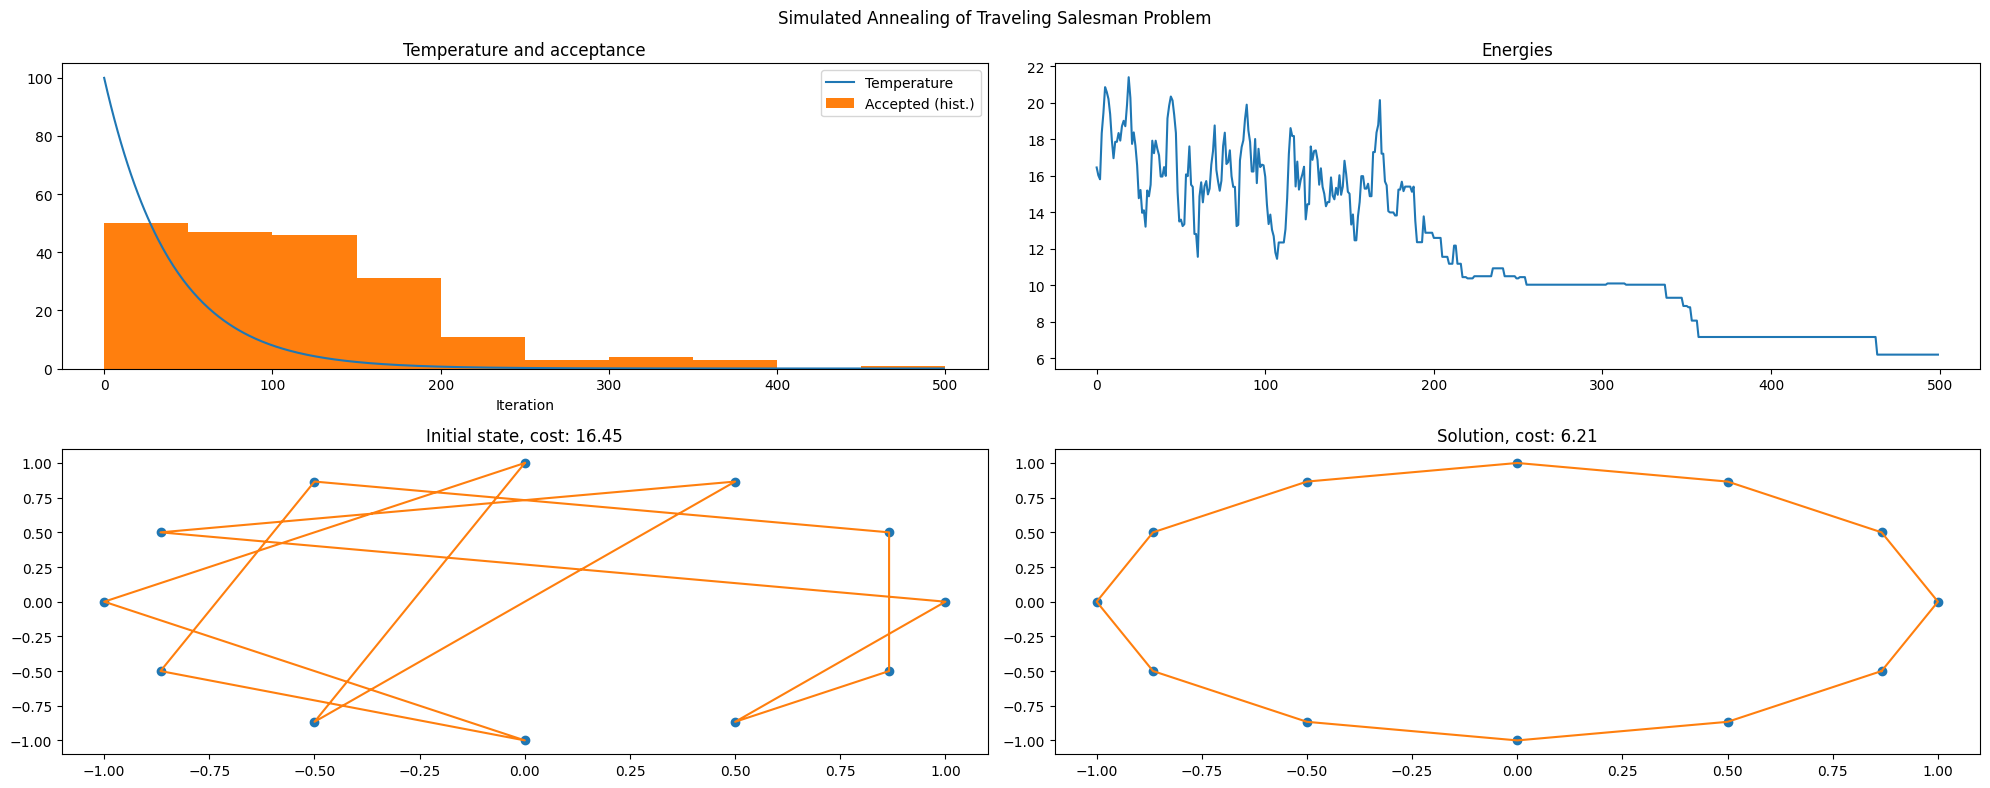

In [44]:
def plot_route(ax, x, y, indices, title):
    ax.set_title(title)
    ax.plot(x, y, 'o')  # draw points
    closed_indices = np.append(indices, indices[0])  # return to start
    ax.plot(x[closed_indices], y[closed_indices], '-')  # draw route

accept_iters = np.where(accepted == 1)[0]

fig, axes = plt.subplots(2, 2, figsize=(20, 8))

axes[0, 0].set_title("Temperature and acceptance")
axes[0, 0].plot(np.arange(N), t_func(np.arange(N)), label="Temperature")
axes[0, 0].hist(accept_iters, range=(0, N), label="Accepted (hist.)")
axes[0, 0].set_xlabel("Iteration")
axes[0, 0].legend()

axes[0, 1].set_title("Energies")
axes[0, 1].plot(energies)
axes[0, 0].set_xlabel("Iteration")

fig.suptitle("Simulated Annealing of Traveling Salesman Problem")

plot_route(axes[1, 0], x, y, initial_state, f"Initial state, cost: {energy(initial_state):.2f}")
plot_route(axes[1, 1], x, y, solution, f"Solution, cost: {energy(solution):.2f}")
fig.tight_layout()

We get the expected solution; for points on a circle, the shortes TSP route is to visit them in order around the circle. Also, the energy curve and acceptance rate seems to taper off at a reasonable speed.

We tried the cooling schemes suggested in the exercise as well, but they did not work very well, so we switched to exponential dropoff. Our experiments taught us that a high initial temperature, coupled with a slow dropoff (that still ends at a low temperature) leads to good results.

### (b) Then modify your progamme to work with costs directly and apply it to the cost matrix from the course homepage.

Since our program is already built for cost matrices, we simply switch out the cost_matrix.
This problem is harder than the debug case, so we adjust our parameters accordingly: Higher number of iterations gives more time to find a solution, higher $t_0$ increases early exploration, and an $\alpha$ closer to $1$ lets the temperature decline slower to better match the higher iteration number.

$$N = 10000$$
$$t_0 = 1000$$
$$\alpha = 0.999$$

In [45]:
cost_matrix = np.array([
    [0, 225, 110, 8, 257, 22, 83, 231, 277, 243, 94, 30, 4, 265, 274, 250, 87, 83, 271, 86],
    [255, 0, 265, 248, 103, 280, 236, 91, 3, 87, 274, 265, 236, 8, 24, 95, 247, 259, 28, 259],
    [87, 236, 0, 95, 248, 110, 25, 274, 250, 271, 9, 244, 83, 250, 248, 280, 29, 26, 239, 7],
    [8, 280, 83, 0, 236, 28, 91, 239, 280, 259, 103, 23, 6, 280, 244, 259, 95, 87, 230, 84],
    [268, 87, 239, 271, 0, 244, 275, 9, 84, 25, 244, 239, 275, 83, 110, 24, 274, 280, 84, 274],
    [21, 265, 99, 29, 259, 0, 99, 230, 265, 271, 87, 5, 22, 239, 236, 250, 87, 95, 271, 91],
    [95, 236, 28, 91, 247, 93, 0, 247, 259, 244, 27, 91, 87, 268, 275, 280, 7, 8, 240, 27],
    [280, 83, 250, 261, 4, 239, 230, 0, 103, 24, 239, 261, 271, 95, 87, 21, 274, 255, 110, 280],
    [247, 9, 280, 274, 84, 255, 259, 99, 0, 87, 255, 274, 280, 3, 27, 83, 259, 244, 28, 274],
    [230, 103, 268, 275, 23, 244, 264, 28, 83, 0, 268, 275, 261, 91, 95, 8, 277, 261, 84, 247],
    [87, 239, 9, 103, 261, 110, 29, 255, 239, 261, 0, 259, 84, 239, 261, 242, 24, 25, 242, 5],
    [30, 255, 95, 30, 247, 4, 87, 274, 242, 255, 99, 0, 24, 280, 274, 259, 91, 83, 247, 91],
    [8, 261, 83, 6, 255, 29, 103, 261, 247, 242, 110, 29, 0, 261, 244, 230, 87, 84, 280, 100],
    [242, 8, 259, 280, 99, 242, 244, 99, 3, 84, 280, 236, 259, 0, 27, 95, 274, 261, 24, 268],
    [274, 22, 250, 236, 83, 261, 247, 103, 22, 91, 250, 236, 261, 25, 0, 103, 255, 261, 5, 247],
    [244, 91, 261, 255, 28, 236, 261, 29, 103, 9, 242, 261, 244, 87, 110, 0, 242, 236, 95, 259],
    [84, 236, 27, 99, 230, 83, 7, 259, 230, 230, 22, 87, 93, 250, 255, 247, 0, 9, 259, 24],
    [91, 242, 28, 87, 250, 110, 6, 271, 271, 255, 27, 103, 84, 250, 271, 244, 5, 0, 271, 29],
    [261, 24, 250, 271, 84, 255, 261, 87, 28, 110, 250, 248, 248, 22, 3, 103, 271, 248, 0, 236],
    [103, 271, 8, 91, 255, 91, 21, 271, 236, 271, 7, 250, 83, 247, 250, 271, 22, 27, 248, 0]
])

n_stations = cost_matrix.shape[0]
stations = np.arange(n_stations)

# draw in circle pattern even though we dont know positions
theta = 2 * np.pi * stations / n_stations
x = np.cos(theta)
y = np.sin(theta)


t_func = get_t_func(1000, 0.999)

np.random.seed(3)
N = 10_000
initial_state = np.random.permutation(np.arange(n_stations))

solution, energies, accepted = simulated_annealing(initial_state, energy, permute, t_func, N)

Again, we plot the solutions. This time the stations do not have a meaningful position in the plane, so we do not include the route plots. Instead, we plot the cost of each part of the route (cost of going from station to station), as a bar chart:

[ 9  0 12  3 11  5 10 19  2 17 16  6  1  8 13 18 14  4  7 15]


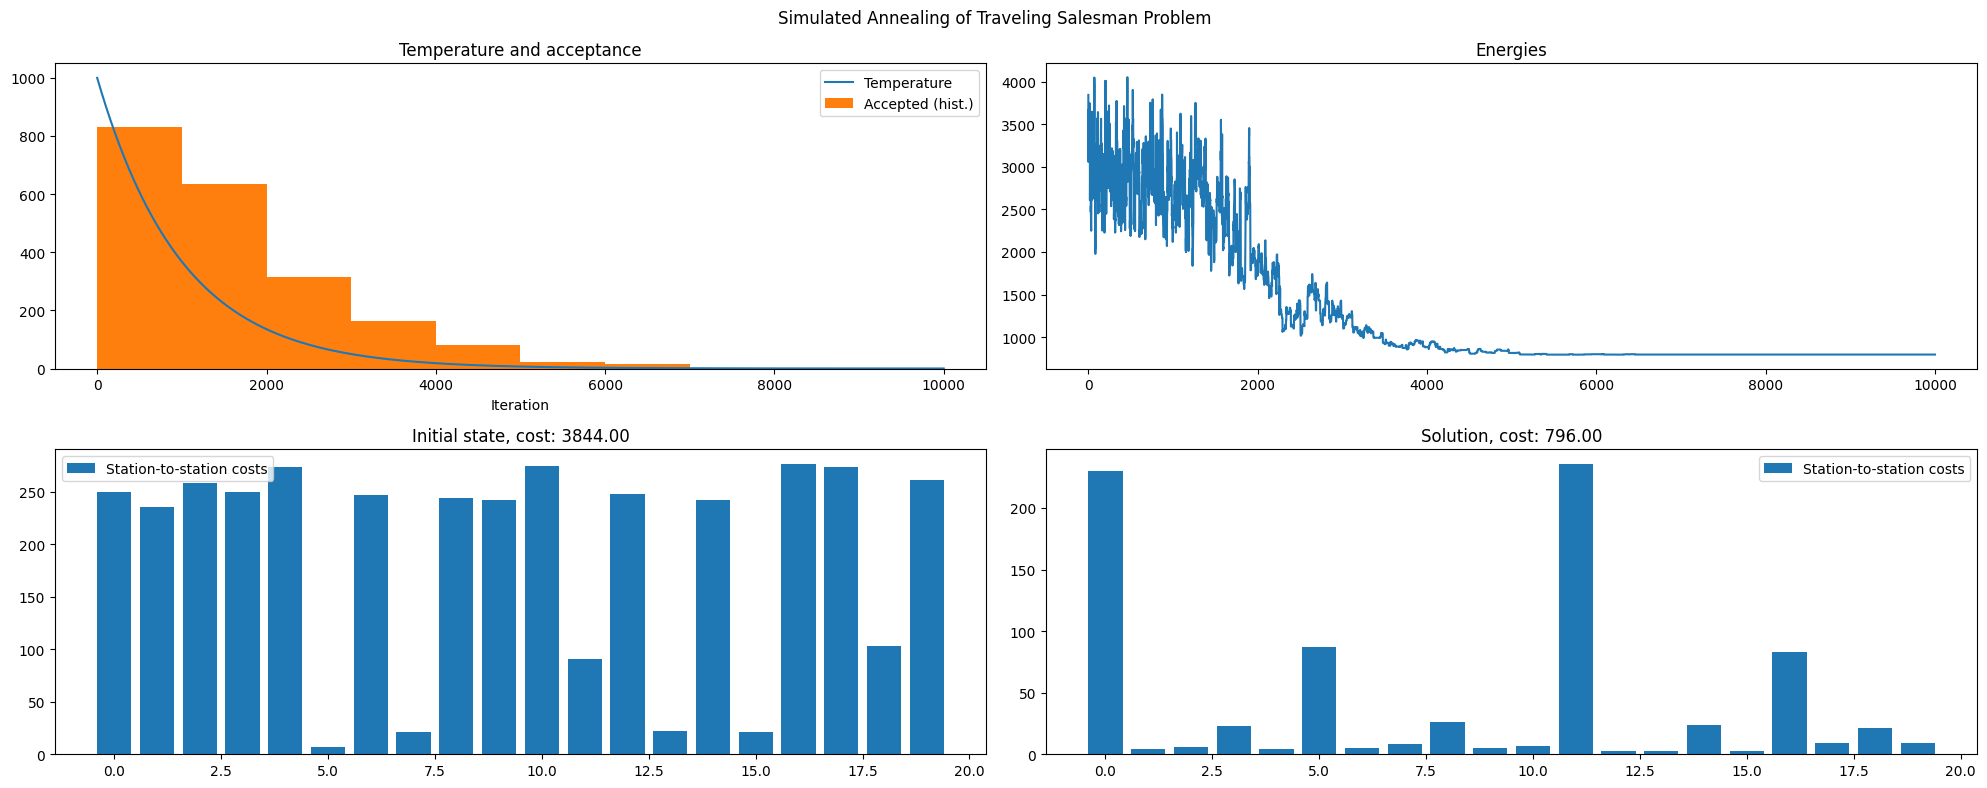

In [46]:
print(solution)
accept_iters = np.where(accepted == 1)[0]

fig, axes = plt.subplots(2, 2, figsize=(20, 8))

axes[0, 0].set_title("Temperature and acceptance")
axes[0, 0].plot(np.arange(N), t_func(np.arange(N)), label="Temperature")
axes[0, 0].hist(accept_iters, range=(0, N), label="Accepted (hist.)")
axes[0, 0].set_xlabel("Iteration")
axes[0, 0].legend()

axes[0, 1].set_title("Energies")
axes[0, 1].plot(energies)
axes[0, 0].set_xlabel("Iteration")

initial_costs = np.array([cost_matrix[initial_state[i], initial_state[(i + 1) % n_stations]] for i in range(n_stations)])
solution_costs = np.array([cost_matrix[solution[i], solution[(i + 1) % n_stations]] for i in range(n_stations)])

axes[1, 0].set_title(f"Initial state, cost: {energy(initial_state):.2f}")
axes[1, 0].bar(np.arange(n_stations), initial_costs, label="Station-to-station costs")
axes[1, 0].legend()

axes[1, 1].set_title(f"Solution, cost: {energy(solution):.2f}")
axes[1, 1].bar(np.arange(n_stations), solution_costs, label="Station-to-station costs")
axes[1, 1].legend()

fig.suptitle("Simulated Annealing of Traveling Salesman Problem")
fig.tight_layout()
plt.show()

We obtain a soultion with cost $796$, where the visit order is:

$$[9, 0, 12, 3, 11, 5, 10, 19, 2, 17, 16, 6, 1, 8, 13, 18, 14, 4, 7, 15]$$

For this problem we do not know the cost of the optimal solution, but from the TA's we've gathered that costs in the range 750-900 are close to optimal.

We also see several signs of the algorithm having convereged to a 'reasonable' solution:
- Acceptance rate drops off gradually
- Energy varies wildly in the beginning, and keeps varying at a smaller scale at later iterations
- Solution cost is much lower than initial state cost